# Project
#### https://www.kaggle.com/c/home-credit-default-risk 


#### In this notebook, we will do the following:
1. Import all the data 
2. Perform basic data exploration (EDA) 
3. Preprocess data (deal with NULL values)
4. Reduce dimension (PCA) and begin feature selection
5. Perform baseline prediction (via Random Forest with GridSearch)
6. Save our processed data and final models for future notebooks

#### Future notebook will develop on feature engineering and modelling.

In [1]:
## IMPORTS ##

# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib for plotting
import matplotlib.pyplot as plt

# garbage collector
import gc


## Explore Data 

### Credit data (application_train and application_test)

In [2]:
# Load data fcn
def load_credit_data(data_path):
    csv_path = os.path.join("data", data_path)
    return pd.read_csv(csv_path)

In [3]:
# Load training data
training_df = load_credit_data ("application_train.csv")
print (training_df.shape)
training_df.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Load test data
testing_df = load_credit_data ("application_test.csv")
print (testing_df.shape)
testing_df.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Check columns to verify that they are identical (except for  TARGET)
# Note, this might change after one-hot encoding (see below)
df_train_attribs = set(training_df)
df_test_attribs = set(testing_df)
print ("Different columns: ", df_train_attribs - df_test_attribs)

# Number of each column type
print ("\nTypes in training:")
print (training_df.dtypes.value_counts())
print ("\nTypes in testing:")
print (testing_df.dtypes.value_counts())

Different columns:  {'TARGET'}

Types in training:
float64    65
int64      41
object     16
dtype: int64

Types in testing:
float64    65
int64      40
object     16
dtype: int64


### Look at application_train

In [6]:
# Look at overall statistical info of training set
training_df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [7]:
# Look at distribution of the target (defaults)
target_counts = training_df['TARGET'].value_counts()
target_counts

0    282686
1     24825
Name: TARGET, dtype: int64

In [8]:
# Get weights - can be used later when dealing with undersampling of defaults
percent_paid = target_counts[0] / training_df.shape [0]
percent_default = target_counts[1] / training_df.shape [0]

print ("Percentage paid loans: ", percent_paid)
print ("Percentage defaulted loans: ", percent_default)

Percentage paid loans:  0.9192711805431351
Percentage defaulted loans:  0.08072881945686496


In [9]:
# Function to calculate missing values 
def get_null_table(df):
    
    # Total missing values
    null_val = df.isnull().sum()
        
    # Percentage of missing values
    null_percent = 100 * null_val / df.shape[0]
        
    # Make a table with the results
    null_table = pd.concat([null_val, null_percent, df.dtypes], axis=1)
        
    # Rename the columns
    null_table_named = null_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values' , 2: 'Type'})
    
    return null_table_named

In [10]:
# Look at NULL entries - will be using this later to determine how to fill them in
test_null_values_table = get_null_table(training_df)
test_df_null_only = test_null_values_table[test_null_values_table['Missing Values'] > 0]
test_df_null_only.head()

,Missing Values,% of Total Values,Type
AMT_ANNUITY,12,0.003902,float64
AMT_GOODS_PRICE,278,0.090403,float64
NAME_TYPE_SUITE,1292,0.420148,object
OWN_CAR_AGE,202929,65.990810,float64
OCCUPATION_TYPE,96391,31.345545,object


#### Look at categorical features (apply one-hot)

In [11]:
# 1) Firstly, look to see which have NULL values.
test_df_cat_null_only = test_df_null_only[test_df_null_only['Type'] == object]
test_df_cat_null_only.head()

,Missing Values,% of Total Values,Type
NAME_TYPE_SUITE,1292,0.420148,object
OCCUPATION_TYPE,96391,31.345545,object
FONDKAPREMONT_MODE,210295,68.386172,object
HOUSETYPE_MODE,154297,50.176091,object
WALLSMATERIAL_MODE,156341,50.840783,object


In [12]:
# 2) Look at the possible values of each column
print (training_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0))
print ("TOTAL: ", sum(training_df.select_dtypes('object').apply(pd.Series.nunique,dropna=False, axis = 0)))

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64
TOTAL:  146


In [13]:
# 3) For those with NULL, see their possible values
for i in (test_df_cat_null_only.index.tolist()):
    print(i)
    print (pd.Series.unique(training_df[i]))

NAME_TYPE_SUITE
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
OCCUPATION_TYPE
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
FONDKAPREMONT_MODE
['reg oper account' nan 'org spec account' 'reg oper spec account'
 'not specified']
HOUSETYPE_MODE
['block of flats' nan 'terraced house' 'specific housing']
WALLSMATERIAL_MODE
['Stone, brick' 'Block' nan 'Panel' 'Mixed' 'Wooden' 'Others' 'Monolithic']
EMERGENCYSTATE_MODE
['No' nan 'Yes']


In [14]:
# 4) Deal with the NULL values for categorical data. Simply make 'Unspecified' column (or similar) if it does not exist.
# Leave the new columns as we will deal with dimensions / feature importance later.
training_df["NAME_TYPE_SUITE"].fillna("Unspecified", inplace=True) 
training_df["OCCUPATION_TYPE"].fillna("Unspecified", inplace=True)
training_df["FONDKAPREMONT_MODE"].fillna("not specified", inplace=True) # Actual current value
training_df["HOUSETYPE_MODE"].fillna("Unspecified", inplace=True)
training_df["WALLSMATERIAL_MODE"].fillna("Unspecified", inplace=True)
training_df["EMERGENCYSTATE_MODE"].fillna("Unspecified", inplace=True)

In [15]:
# 5) Now, apply 'one-hot' encoding
training_df = pd.get_dummies(training_df)
training_df.shape

(307511, 251)

#### Look at numerical features 

In [16]:
# 1) Firstly, look to see which have NULL values. 
test_df_num_null_only = test_df_null_only[test_df_null_only['Type'] != object]
test_df_num_null_only.head()

,Missing Values,% of Total Values,Type
AMT_ANNUITY,12,0.003902,float64
AMT_GOODS_PRICE,278,0.090403,float64
OWN_CAR_AGE,202929,65.990810,float64
CNT_FAM_MEMBERS,2,0.000650,float64
EXT_SOURCE_1,173378,56.381073,float64


In [17]:
# 2) Look at the statistics of the NULL columns to see which variable is reasonable to replace NULL with
for i in (test_df_num_null_only.index.tolist()):
    print(i)
    print ("Mean: ", pd.Series.mean(training_df[i]), "Median: ", pd.Series.median(training_df[i]), "Min: ", pd.Series.min(training_df[i]), "Max: ", pd.Series.max(training_df[i]))

AMT_ANNUITY
Mean:  27108.573909183444 Median:  24903.0 Min:  1615.5 Max:  258025.5
AMT_GOODS_PRICE
Mean:  538396.2074288895 Median:  450000.0 Min:  40500.0 Max:  4050000.0
OWN_CAR_AGE
Mean:  12.061090818687727 Median:  9.0 Min:  0.0 Max:  91.0
CNT_FAM_MEMBERS
Mean:  2.152665450442101 Median:  2.0 Min:  1.0 Max:  20.0
EXT_SOURCE_1
Mean:  0.5021298056566621 Median:  0.5059979305057544 Min:  0.014568132412445587 Max:  0.962692770561306
EXT_SOURCE_2
Mean:  0.5143926741308463 Median:  0.5659614260608526 Min:  8.173616518884397e-08 Max:  0.8549996664047012
EXT_SOURCE_3
Mean:  0.5108529061800121 Median:  0.5352762504724826 Min:  0.0005272652387098817 Max:  0.8960095494948396
APARTMENTS_AVG
Mean:  0.11744049917466033 Median:  0.0876 Min:  0.0 Max:  1.0
BASEMENTAREA_AVG
Mean:  0.08844221905180052 Median:  0.0763 Min:  0.0 Max:  1.0
YEARS_BEGINEXPLUATATION_AVG
Mean:  0.9777348581622732 Median:  0.9816 Min:  0.0 Max:  1.0
YEARS_BUILD_AVG
Mean:  0.752471432592686 Median:  0.7552 Min:  0.0 Max:  1.

In [18]:
# 3) Deal with the NULL values - choose MEDIAN - most MEDIANs are close enough to MEANS with the exceptions of outliers, 
# which make the MEANS larger. Multiple imputation would be a better choice (possible TODO). 
training_df.fillna(training_df.median(), inplace=True) # Could use Imputer (before Merge) later.

### Look at application_test

In [19]:
# Look at overall statistical info of testing set
testing_df.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000


In [20]:
# Look at NULL entries - will be using this later to determine how to fill them in
test_null_values_table = get_null_table(testing_df)
test_df_null_only = test_null_values_table[test_null_values_table['Missing Values'] > 0]
test_df_null_only.head()

,Missing Values,% of Total Values,Type
AMT_ANNUITY,24,0.049237,float64
NAME_TYPE_SUITE,911,1.868948,object
OWN_CAR_AGE,32312,66.289184,float64
OCCUPATION_TYPE,15605,32.014197,object
EXT_SOURCE_1,20532,42.122107,float64


#### Look at categorical features (apply one-hot) 

In [21]:
# 1) Firstly, look to see which have NULL values.
test_df_cat_null_only = test_df_null_only[test_df_null_only['Type'] == object]
test_df_cat_null_only.head()

,Missing Values,% of Total Values,Type
NAME_TYPE_SUITE,911,1.868948,object
OCCUPATION_TYPE,15605,32.014197,object
FONDKAPREMONT_MODE,32797,67.284179,object
HOUSETYPE_MODE,23619,48.455194,object
WALLSMATERIAL_MODE,23893,49.017315,object


In [22]:
# 2) Look at the possible values of each column
print (testing_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0))
print ("TOTAL: " , sum(testing_df.select_dtypes('object').apply(pd.Series.nunique,dropna=False, axis = 0)))

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64
TOTAL:  143


In [23]:
# 3) For those with NULL, see their possible values
for i in (test_df_cat_null_only.index.tolist()):
    print(i)
    print (pd.Series.unique(testing_df[i]))

NAME_TYPE_SUITE
['Unaccompanied' nan 'Family' 'Spouse, partner' 'Group of people'
 'Other_B' 'Children' 'Other_A']
OCCUPATION_TYPE
[nan 'Low-skill Laborers' 'Drivers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Laborers' 'Managers' 'Accountants' 'Medicine staff'
 'Security staff' 'Private service staff' 'Secretaries' 'Cleaning staff'
 'Cooking staff' 'HR staff' 'Waiters/barmen staff' 'Realty agents'
 'IT staff']
FONDKAPREMONT_MODE
[nan 'reg oper account' 'not specified' 'org spec account'
 'reg oper spec account']
HOUSETYPE_MODE
['block of flats' nan 'specific housing' 'terraced house']
WALLSMATERIAL_MODE
['Stone, brick' nan 'Panel' 'Block' 'Wooden' 'Mixed' 'Monolithic' 'Others']
EMERGENCYSTATE_MODE
['No' nan 'Yes']


In [24]:
# 4) Deal with the NULL values for categorical data. 
testing_df["NAME_TYPE_SUITE"].fillna("Unspecified", inplace=True) 
testing_df["OCCUPATION_TYPE"].fillna("Unspecified", inplace=True)
testing_df["FONDKAPREMONT_MODE"].fillna("not specified", inplace=True) # Actual current value
testing_df["HOUSETYPE_MODE"].fillna("Unspecified", inplace=True)
testing_df["WALLSMATERIAL_MODE"].fillna("Unspecified", inplace=True)
testing_df["EMERGENCYSTATE_MODE"].fillna("Unspecified", inplace=True)

In [25]:
# 5) Now, apply one-hot encoding
testing_df = pd.get_dummies(testing_df)
testing_df.shape

(48744, 247)

In [26]:
# 6) Check to see which columns differ b/t training and testing
df_train_attribs = set(training_df)
df_test_attribs = set(testing_df)
print ("Different columns: ", df_train_attribs - df_test_attribs)

Different columns:  {'NAME_FAMILY_STATUS_Unknown', 'TARGET', 'NAME_INCOME_TYPE_Maternity leave', 'CODE_GENDER_XNA'}


In [27]:
# 7) Add the columns into testing (do NOT drop)

for column in {'NAME_INCOME_TYPE_Maternity leave', 'NAME_FAMILY_STATUS_Unknown', 'CODE_GENDER_XNA'}:
    testing_df[column] = 0
    
testing_df.shape    

(48744, 250)

#### Look at numerical features 

In [28]:
# 1) Firstly, look to see which have NULL values. 
test_df_num_null_only = test_df_null_only[test_df_null_only['Type'] != object]
test_df_num_null_only.head()

,Missing Values,% of Total Values,Type
AMT_ANNUITY,24,0.049237,float64
OWN_CAR_AGE,32312,66.289184,float64
EXT_SOURCE_1,20532,42.122107,float64
EXT_SOURCE_2,8,0.016412,float64
EXT_SOURCE_3,8668,17.782701,float64


In [29]:
# 2) Look at the statistics of the NULL columns to see which variable is reasonable to replace NULL with
for i in (test_df_num_null_only.index.tolist()):
    print(i)
    print ("Mean: ", pd.Series.mean(testing_df[i]), "Median: ", pd.Series.median(testing_df[i]), "Min: ", pd.Series.min(testing_df[i]), "Max: ", pd.Series.max(testing_df[i]))

AMT_ANNUITY
Mean:  29426.240209359607 Median:  26199.0 Min:  2295.0 Max:  180576.0
OWN_CAR_AGE
Mean:  11.786027263875365 Median:  9.0 Min:  0.0 Max:  74.0
EXT_SOURCE_1
Mean:  0.5011798106396288 Median:  0.5067712615026179 Min:  0.013457910498691777 Max:  0.9391445326561508
EXT_SOURCE_2
Mean:  0.518021075670542 Median:  0.5587579430597367 Min:  8.09785587553435e-06 Max:  0.8549996664047012
EXT_SOURCE_3
Mean:  0.5001056254095644 Median:  0.5190973382084597 Min:  0.0005272652387098817 Max:  0.8825303127941461
APARTMENTS_AVG
Mean:  0.12238773786056177 Median:  0.0928 Min:  0.0 Max:  1.0
BASEMENTAREA_AVG
Mean:  0.09006548358053325 Median:  0.0781 Min:  0.0 Max:  1.0
YEARS_BEGINEXPLUATATION_AVG
Mean:  0.9788281597651234 Median:  0.9816 Min:  0.0 Max:  1.0
YEARS_BUILD_AVG
Mean:  0.7511370908661243 Median:  0.7552 Min:  0.0 Max:  1.0
COMMONAREA_AVG
Mean:  0.047623660567905825 Median:  0.0227 Min:  0.0 Max:  1.0
ELEVATORS_AVG
Mean:  0.0851682954786654 Median:  0.0 Min:  0.0 Max:  1.0
ENTRANCES_

In [30]:
# 3) As before, deal with the NULL values - choose MEDIAN - most MEDIANs are close enough to MEANS with the exceptions of outliers, 
# which make the MEANS larger. Multiple imputation would be a better choice (possible TODO). 
testing_df.fillna(testing_df.median(), inplace=True) # Could use Imputer (before Merge) later.

### Supplementary datasets

### Look at bureau and bureau_balance

#### Bureau

In [31]:
# Load bureau
bureau_df = load_credit_data ("bureau.csv")
print (bureau_df.shape)
bureau_df.head()

(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


##### Deal with NULL values

In [32]:
test_null_values_table = get_null_table(bureau_df)
test_df_null_only = test_null_values_table[test_null_values_table['Missing Values'] > 0]
test_df_null_only.head(10)

,Missing Values,% of Total Values,Type
DAYS_CREDIT_ENDDATE,105553,6.149573,float64
DAYS_ENDDATE_FACT,633653,36.916958,float64
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264,float64
AMT_CREDIT_SUM,13,0.000757,float64
AMT_CREDIT_SUM_DEBT,257669,15.011932,float64
AMT_CREDIT_SUM_LIMIT,591780,34.477415,float64
AMT_ANNUITY,1226791,71.473490,float64


In [33]:
# Numerics. Look at statistical info
test_df_num_null_only = test_df_null_only[test_df_null_only['Type'] != object]
for i in (test_df_num_null_only.index.tolist()):
    print(i)
    print ("Mean: ", pd.Series.mean(bureau_df[i]), "Median: ", pd.Series.median(bureau_df[i]), "Min: ", pd.Series.min(bureau_df[i]), "Max: ", pd.Series.max(bureau_df[i]))

DAYS_CREDIT_ENDDATE
Mean:  510.51736230309615 Median:  -330.0 Min:  -42060.0 Max:  31199.0
DAYS_ENDDATE_FACT
Mean:  -1017.43714806862 Median:  -897.0 Min:  -42023.0 Max:  0.0
AMT_CREDIT_MAX_OVERDUE
Mean:  3825.417661273144 Median:  0.0 Min:  0.0 Max:  115987185.0
AMT_CREDIT_SUM
Mean:  354994.59191768744 Median:  125518.5 Min:  0.0 Max:  585000000.0
AMT_CREDIT_SUM_DEBT
Mean:  137085.11995216075 Median:  0.0 Min:  -4705600.32 Max:  170100000.0
AMT_CREDIT_SUM_LIMIT
Mean:  6229.514980300509 Median:  0.0 Min:  -586406.115 Max:  4705600.32
AMT_ANNUITY
Mean:  15712.757700078355 Median:  0.0 Min:  0.0 Max:  118453423.5


In [34]:
# To be conservative with payment info, use the median
bureau_df.fillna(bureau_df.median(), inplace=True)

#### Bureau balance

In [35]:
# Load bureau balance
bureau_bal_df = load_credit_data ("bureau_balance.csv")
print (bureau_bal_df.shape)
bureau_bal_df.head()

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


##### Deal with NULL values

In [36]:
test_null_values_table = get_null_table(bureau_bal_df)
test_df_null_only = test_null_values_table[test_null_values_table['Missing Values'] > 0]
test_df_null_only.head()

,Missing Values,% of Total Values,Type


##### Create the aggregate DF

In [37]:
# Look at status - count how many times each status occurs for each bureau ID - OMIT
# bureau_grouped_counts = bureau_bal_df.groupby('SK_ID_BUREAU')['STATUS'].value_counts(normalize = False)
# bureau_grouped_counts_unstacked = bureau_grouped_counts.unstack('STATUS')
# labels = [s + '_df_avg_bureau' for s in bureau_grouped_counts_unstacked.columns]
# bureau_grouped_counts_unstacked.columns = labels

In [38]:
# Create a new df with key = SK_BUREAU_ID and the sums of the numeric columns

 # One-hot categorical column
bureau_bal_df = pd.concat([bureau_bal_df, pd.get_dummies(bureau_bal_df['STATUS'], prefix='STATUS_')], axis=1)
   
# Get means of columns grouped by SK_ID_CURR
bureau_bal_df_sum = bureau_bal_df.groupby('SK_ID_BUREAU').sum()

labels = ['df_sum_bureau_bal_' + s for s in bureau_bal_df_sum.columns]
bureau_bal_df_sum.columns = labels

bureau_bal_df_sum.head()

,df_sum_bureau_bal_MONTHS_BALANCE,df_sum_bureau_bal_STATUS__0,df_sum_bureau_bal_STATUS__1,df_sum_bureau_bal_STATUS__2,df_sum_bureau_bal_STATUS__3,df_sum_bureau_bal_STATUS__4,df_sum_bureau_bal_STATUS__5,df_sum_bureau_bal_STATUS__C,df_sum_bureau_bal_STATUS__X
SK_ID_BUREAU,,,,,,,,,
5001709,-4656,0,0,0,0,0,0,86,11
5001710,-3403,5,0,0,0,0,0,48,30
5001711,-6,3,0,0,0,0,0,0,1
5001712,-171,10,0,0,0,0,0,9,0
5001713,-231,0,0,0,0,0,0,0,22


### Combine the two - bureau and bureau balance

In [39]:
# Merge by SK_ID_BUREAU
bureau_full_df = bureau_df.merge(right=bureau_bal_df_sum.reset_index(), on = 'SK_ID_BUREAU', how = 'left')
bureau_full_df.shape

(1716428, 26)

In [40]:
bureau_full_df.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,AMT_ANNUITY,df_sum_bureau_bal_MONTHS_BALANCE,df_sum_bureau_bal_STATUS__0,df_sum_bureau_bal_STATUS__1,df_sum_bureau_bal_STATUS__2,df_sum_bureau_bal_STATUS__3,df_sum_bureau_bal_STATUS__4,df_sum_bureau_bal_STATUS__5,df_sum_bureau_bal_STATUS__C,df_sum_bureau_bal_STATUS__X
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,0.0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,-897.0,0.0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,-897.0,0.0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,-330.0,-897.0,0.0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,-897.0,77674.5,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Deal with NULLs from the merges - if no info exists, just assume 0.
bureau_full_df.fillna(0, inplace=True)

In [42]:
# Verify no NULLs
test_null_values_table = get_null_table(bureau_full_df)
test_df_null_only = test_null_values_table[test_null_values_table['Missing Values'] > 0]
test_df_null_only.head()

,Missing Values,% of Total Values,Type


##### Create the aggregate DF

In [43]:
# One hot categorical columns - 3 of them.
bureau_full_df = pd.concat([bureau_full_df, pd.get_dummies(bureau_full_df['CREDIT_ACTIVE'], prefix='CREDIT_ACTIVE_')], axis=1)
bureau_full_df = pd.concat([bureau_full_df, pd.get_dummies(bureau_full_df['CREDIT_CURRENCY'], prefix='CREDIT_CURRENCY_')], axis=1)
bureau_full_df = pd.concat([bureau_full_df, pd.get_dummies(bureau_full_df['CREDIT_TYPE'], prefix='CREDIT_TYPE_')], axis=1)

# Get counts of number of bureau balances
bureau_full_df_prevs = bureau_full_df[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
bureau_full_df['SK_ID_BUREAU'] = bureau_full_df['SK_ID_CURR'].map(bureau_full_df_prevs['SK_ID_BUREAU'])

# Get means of columns grouped by SK_ID_CURR
bureau_full_df_avg = bureau_full_df.groupby('SK_ID_CURR').mean()

labels = ['df_avg_bureau_full_' + s for s in bureau_full_df_avg.columns]
bureau_full_df_avg.columns = labels

bureau_full_df_avg.head()

,df_avg_bureau_full_SK_ID_BUREAU,df_avg_bureau_full_DAYS_CREDIT,df_avg_bureau_full_CREDIT_DAY_OVERDUE,df_avg_bureau_full_DAYS_CREDIT_ENDDATE,df_avg_bureau_full_DAYS_ENDDATE_FACT,df_avg_bureau_full_AMT_CREDIT_MAX_OVERDUE,df_avg_bureau_full_CNT_CREDIT_PROLONG,df_avg_bureau_full_AMT_CREDIT_SUM,df_avg_bureau_full_AMT_CREDIT_SUM_DEBT,df_avg_bureau_full_AMT_CREDIT_SUM_LIMIT,...,df_avg_bureau_full_CREDIT_TYPE__Interbank credit,df_avg_bureau_full_CREDIT_TYPE__Loan for business development,df_avg_bureau_full_CREDIT_TYPE__Loan for purchase of shares (margin lending),df_avg_bureau_full_CREDIT_TYPE__Loan for the purchase of equipment,df_avg_bureau_full_CREDIT_TYPE__Loan for working capital replenishment,df_avg_bureau_full_CREDIT_TYPE__Microloan,df_avg_bureau_full_CREDIT_TYPE__Mobile operator loan,df_avg_bureau_full_CREDIT_TYPE__Mortgage,df_avg_bureau_full_CREDIT_TYPE__Real estate loan,df_avg_bureau_full_CREDIT_TYPE__Unknown type of loan
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,7.0,-735.000000,0.0,82.428571,-856.142857,0.000000,0.0,207623.571429,85240.928571,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100002,8.0,-874.000000,0.0,-344.250000,-747.375000,1050.643125,0.0,108131.945625,30722.625000,3998.570625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100003,4.0,-1400.750000,0.0,-544.500000,-1047.250000,0.000000,0.0,254350.125000,0.000000,202500.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,2.0,-867.000000,0.0,-488.500000,-532.500000,0.000000,0.0,94518.900000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100005,3.0,-190.666667,0.0,439.333333,-639.000000,0.000000,0.0,219042.000000,189469.500000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Clean up memory
gc.enable()
del bureau_df, bureau_bal_df, bureau_bal_df_sum, bureau_full_df, bureau_full_df_prevs 
gc.collect()

695

In [45]:
# TODO: If time permits, I would like to perform other aggregates (min, max, median).
# Other features to consider:
# (1) Better joining of the balance table ... look at 
#     (a) months bins (summation isn't helpful)
#     (b) incorporating a count of number of entries per bureau to keep track of percentages 
# Also, look at multiple imputation.

### Look at previous_application

In [46]:
# Load previous application
previous_app_df = load_credit_data ("previous_application.csv")
print (previous_app_df.shape)
previous_app_df.head()

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


#### Deal with NULL values

In [47]:
test_null_values_table = get_null_table(previous_app_df)
test_df_null_only = test_null_values_table[test_null_values_table['Missing Values'] > 0]
test_df_null_only.head(20)

,Missing Values,% of Total Values,Type
AMT_ANNUITY,372235,22.286665,float64
AMT_CREDIT,1,0.000060,float64
AMT_DOWN_PAYMENT,895844,53.636480,float64
AMT_GOODS_PRICE,385515,23.081773,float64
RATE_DOWN_PAYMENT,895844,53.636480,float64
RATE_INTEREST_PRIMARY,1664263,99.643698,float64
RATE_INTEREST_PRIVILEGED,1664263,99.643698,float64
NAME_TYPE_SUITE,820405,49.119754,object
CNT_PAYMENT,372230,22.286366,float64
PRODUCT_COMBINATION,346,0.020716,object


##### Categorical NULLs

In [48]:
# Categorical. Look to see if we can use any existing entries.
test_df_cat_null_only = test_df_null_only[test_df_null_only['Type'] == object]
for i in (test_df_cat_null_only.index.tolist()):
    print(i)
    print (pd.Series.unique(previous_app_df[i]))

NAME_TYPE_SUITE
[nan 'Unaccompanied' 'Spouse, partner' 'Family' 'Children' 'Other_B'
 'Other_A' 'Group of people']
PRODUCT_COMBINATION
['POS mobile with interest' 'Cash X-Sell: low' 'Cash X-Sell: high'
 'Cash X-Sell: middle' 'Cash Street: high' 'Cash'
 'POS household without interest' 'POS household with interest'
 'POS other with interest' 'Card X-Sell' 'POS mobile without interest'
 'Card Street' 'POS industry with interest' 'Cash Street: low'
 'POS industry without interest' 'Cash Street: middle'
 'POS others without interest' nan]


In [49]:
previous_app_df["NAME_TYPE_SUITE"].fillna("Unspecified", inplace=True) 
previous_app_df["PRODUCT_COMBINATION"].fillna("Unspecified", inplace=True)

##### Numerical NULLs

In [50]:
# Numerics. Look at statistical info
test_df_num_null_only = test_df_null_only[test_df_null_only['Type'] != object]
for i in (test_df_num_null_only.index.tolist()):
    print(i)
    print ("Mean: ", pd.Series.mean(previous_app_df[i]), "Median: ", pd.Series.median(previous_app_df[i]), "Min: ", pd.Series.min(previous_app_df[i]), "Max: ", pd.Series.max(previous_app_df[i]))

AMT_ANNUITY
Mean:  15955.120659450406 Median:  11250.0 Min:  0.0 Max:  418058.145
AMT_CREDIT
Mean:  196114.02121797804 Median:  80541.0 Min:  0.0 Max:  6905160.0
AMT_DOWN_PAYMENT
Mean:  6697.402138796564 Median:  1638.0 Min:  -0.9 Max:  3060045.0
AMT_GOODS_PRICE
Mean:  227847.27928334344 Median:  112320.0 Min:  0.0 Max:  6905160.0
RATE_DOWN_PAYMENT
Mean:  0.0796368154283738 Median:  0.051605084707529336 Min:  -1.4978763414307847e-05 Max:  1.0
RATE_INTEREST_PRIMARY
Mean:  0.18835688954982696 Median:  0.1891221806641732 Min:  0.03478125354187918 Max:  1.0
RATE_INTEREST_PRIVILEGED
Mean:  0.7735025434991628 Median:  0.8350951374207188 Min:  0.3731501057082452 Max:  1.0
CNT_PAYMENT
Mean:  16.0540815603274 Median:  12.0 Min:  0.0 Max:  84.0
DAYS_FIRST_DRAWING
Mean:  342209.85503871535 Median:  365243.0 Min:  -2922.0 Max:  365243.0
DAYS_FIRST_DUE
Mean:  13826.269336879443 Median:  -831.0 Min:  -2892.0 Max:  365243.0
DAYS_LAST_DUE_1ST_VERSION
Mean:  33767.77405382746 Median:  -361.0 Min:  -280

In [51]:
# To be conservative with payment info, use the median
previous_app_df.fillna(previous_app_df.median(), inplace=True)

#### Create the aggregate DF

In [52]:
# Create a new df with key = SK_ID_CURR and count of previous applications and the means of the numeric columns

# One hot categorical columns - done in a DF due to high volume of columns
previous_categories = [s for s in previous_app_df.columns if previous_app_df[s].dtype == 'object']
previous_dummies = pd.DataFrame()
for f_ in previous_categories:
    previous_dummies = pd.concat([previous_dummies, pd.get_dummies(previous_app_df[f_], prefix=f_).astype(np.uint8)], axis=1)
    
previous_app_df = pd.concat([previous_app_df, previous_dummies], axis=1)

# Get counts of number previous applications
previous_app_df_prevs = previous_app_df[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_app_df['SK_ID_PREV'] = previous_app_df['SK_ID_CURR'].map(previous_app_df_prevs['SK_ID_PREV'])

# Get means of columns grouped by SK_ID_CURR
previous_app_df_avg = previous_app_df.groupby('SK_ID_CURR').mean()

labels = ['df_avg_previous_app_' + s for s in previous_app_df_avg.columns]
previous_app_df_avg.columns = labels

previous_app_df_avg.head()

,df_avg_previous_app_SK_ID_PREV,df_avg_previous_app_AMT_ANNUITY,df_avg_previous_app_AMT_APPLICATION,df_avg_previous_app_AMT_CREDIT,df_avg_previous_app_AMT_DOWN_PAYMENT,df_avg_previous_app_AMT_GOODS_PRICE,df_avg_previous_app_HOUR_APPR_PROCESS_START,df_avg_previous_app_NFLAG_LAST_APPL_IN_DAY,df_avg_previous_app_RATE_DOWN_PAYMENT,df_avg_previous_app_RATE_INTEREST_PRIMARY,...,df_avg_previous_app_PRODUCT_COMBINATION_Cash X-Sell: middle,df_avg_previous_app_PRODUCT_COMBINATION_POS household with interest,df_avg_previous_app_PRODUCT_COMBINATION_POS household without interest,df_avg_previous_app_PRODUCT_COMBINATION_POS industry with interest,df_avg_previous_app_PRODUCT_COMBINATION_POS industry without interest,df_avg_previous_app_PRODUCT_COMBINATION_POS mobile with interest,df_avg_previous_app_PRODUCT_COMBINATION_POS mobile without interest,df_avg_previous_app_PRODUCT_COMBINATION_POS other with interest,df_avg_previous_app_PRODUCT_COMBINATION_POS others without interest,df_avg_previous_app_PRODUCT_COMBINATION_Unspecified
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1.0,3951.000,24835.50,23787.00,2520.0,24835.50,13.000000,1.0,0.104326,0.189122,...,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
100002,1.0,9251.775,179055.00,179055.00,0.0,179055.00,9.000000,1.0,0.000000,0.189122,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
100003,3.0,56553.990,435436.50,484191.00,2841.0,435436.50,14.666667,1.0,0.050555,0.189122,...,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0
100004,1.0,5357.250,24282.00,20106.00,4860.0,24282.00,5.000000,1.0,0.212008,0.189122,...,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0
100005,2.0,8031.600,22308.75,20076.75,3051.0,78468.75,10.500000,1.0,0.080285,0.189122,...,0.0,0.000000,0.0,0.000000,0.0,0.5,0.0,0.0,0.0,0.0


In [53]:
# Clean up memory
del previous_app_df, previous_dummies, previous_app_df_prevs
gc.collect()

554

In [54]:
# TODO: If time permits, I would like to perform other aggregates (min, max, median).
# Other features to consider:
# (1) difference between AMT_INSTALMENT and AMT_PAYMENT on average per client
# Also, look at multiple imputation.

### Look at credit_card_balance

In [55]:
# Load credit card balance
credit_card_df = load_credit_data ("credit_card_balance.csv")
print (credit_card_df.shape)
credit_card_df.head()

(3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


#### Deal with NULLs

In [56]:
test_null_values_table = get_null_table(credit_card_df)
test_df_null_only = test_null_values_table[test_null_values_table['Missing Values'] > 0]
test_df_null_only.head(15)

,Missing Values,% of Total Values,Type
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872,float64
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872,float64
AMT_DRAWINGS_POS_CURRENT,749816,19.524872,float64
AMT_INST_MIN_REGULARITY,305236,7.948208,float64
AMT_PAYMENT_CURRENT,767988,19.998063,float64
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872,float64
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872,float64
CNT_DRAWINGS_POS_CURRENT,749816,19.524872,float64
CNT_INSTALMENT_MATURE_CUM,305236,7.948208,float64


In [57]:
# Numerics only - look at statistical info
test_df_num_null_only = test_df_null_only[test_df_null_only['Type'] != object]
for i in (test_df_num_null_only.index.tolist()):
    print(i)
    print ("Mean: ", pd.Series.mean(credit_card_df[i]), "Median: ", pd.Series.median(credit_card_df[i]), "Min: ", pd.Series.min(credit_card_df[i]), "Max: ", pd.Series.max(credit_card_df[i]))

AMT_DRAWINGS_ATM_CURRENT
Mean:  5961.324822059312 Median:  0.0 Min:  -6827.31 Max:  2115000.0
AMT_DRAWINGS_OTHER_CURRENT
Mean:  288.16958242463346 Median:  0.0 Min:  0.0 Max:  1529847.0
AMT_DRAWINGS_POS_CURRENT
Mean:  2968.804847683069 Median:  0.0 Min:  0.0 Max:  2239274.16
AMT_INST_MIN_REGULARITY
Mean:  3540.204128515209 Median:  0.0 Min:  0.0 Max:  202882.005
AMT_PAYMENT_CURRENT
Mean:  10280.53770200115 Median:  2702.7 Min:  0.0 Max:  4289207.445
CNT_DRAWINGS_ATM_CURRENT
Mean:  0.3094490334237611 Median:  0.0 Min:  0.0 Max:  51.0
CNT_DRAWINGS_OTHER_CURRENT
Mean:  0.004812496117128124 Median:  0.0 Min:  0.0 Max:  12.0
CNT_DRAWINGS_POS_CURRENT
Mean:  0.5594791256807968 Median:  0.0 Min:  0.0 Max:  165.0
CNT_INSTALMENT_MATURE_CUM
Mean:  20.825083817151313 Median:  15.0 Min:  0.0 Max:  120.0


In [58]:
# To be conservative with payment info, use the median
credit_card_df.fillna(credit_card_df.median(), inplace=True)

#### Create the aggregate DF

In [59]:
# Create a new df with key = SK_ID_CURR and count of previous applications and the means of the numeric columns

 # One-hot categorical column
credit_card_df = pd.concat([credit_card_df, pd.get_dummies(credit_card_df['NAME_CONTRACT_STATUS'], prefix='NAME_CONTRACT_STATUS_')], axis=1)
   
# Get counts of number previous applications
credit_card_df_prevs = credit_card_df[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card_df['SK_ID_PREV'] = credit_card_df['SK_ID_CURR'].map(credit_card_df_prevs['SK_ID_PREV'])

# Get means of columns grouped by SK_ID_CURR
credit_card_df_avg = credit_card_df.groupby('SK_ID_CURR').mean()

labels = ['df_avg_credit_card_' + s for s in credit_card_df_avg.columns]
credit_card_df_avg.columns = labels

credit_card_df_avg.head()

,df_avg_credit_card_SK_ID_PREV,df_avg_credit_card_MONTHS_BALANCE,df_avg_credit_card_AMT_BALANCE,df_avg_credit_card_AMT_CREDIT_LIMIT_ACTUAL,df_avg_credit_card_AMT_DRAWINGS_ATM_CURRENT,df_avg_credit_card_AMT_DRAWINGS_CURRENT,df_avg_credit_card_AMT_DRAWINGS_OTHER_CURRENT,df_avg_credit_card_AMT_DRAWINGS_POS_CURRENT,df_avg_credit_card_AMT_INST_MIN_REGULARITY,df_avg_credit_card_AMT_PAYMENT_CURRENT,...,df_avg_credit_card_CNT_INSTALMENT_MATURE_CUM,df_avg_credit_card_SK_DPD,df_avg_credit_card_SK_DPD_DEF,df_avg_credit_card_NAME_CONTRACT_STATUS__Active,df_avg_credit_card_NAME_CONTRACT_STATUS__Approved,df_avg_credit_card_NAME_CONTRACT_STATUS__Completed,df_avg_credit_card_NAME_CONTRACT_STATUS__Demand,df_avg_credit_card_NAME_CONTRACT_STATUS__Refused,df_avg_credit_card_NAME_CONTRACT_STATUS__Sent proposal,df_avg_credit_card_NAME_CONTRACT_STATUS__Signed
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,6.0,-3.5,0.000000,270000.000000,0.000000,0.000000,0.0,0.0,0.000000,2702.700000,...,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100011,74.0,-38.5,54482.111149,164189.189189,2432.432432,2432.432432,0.0,0.0,3902.759392,4843.064189,...,25.621622,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100013,96.0,-48.5,18159.919219,131718.750000,5953.125000,5953.125000,0.0,0.0,1348.479375,7168.346250,...,18.447917,0.010417,0.010417,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100021,17.0,-10.0,0.000000,675000.000000,0.000000,0.000000,0.0,0.0,0.000000,2702.700000,...,0.000000,0.000000,0.000000,0.411765,0.0,0.588235,0.0,0.0,0.0,0.0
100023,8.0,-7.5,0.000000,135000.000000,0.000000,0.000000,0.0,0.0,0.000000,2702.700000,...,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [60]:
# Clean up memory
del credit_card_df, credit_card_df_prevs 
gc.collect()

310

In [61]:
# TODO: If time permits, I would like to perform other aggregates (min, max, median).
# Other features to consider:
# (1) difference between AMT_CREDIT_LIMIT_ACTUAL and AMT_BALANCE on average per client
# (2) difference between AMT_PAYMENT_TOTAL_CURRENT and AMT_INST_MIN_REGULARITY on average per client
# Also, look at multiple imputation.

### Look at POS_CASH_balance

In [62]:
# Load pos cash balance
pos_cash_df = load_credit_data ("POS_CASH_balance.csv")
print (pos_cash_df.shape)
pos_cash_df.head()

(10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


#### Deal with NULLs


In [63]:
test_null_values_table = get_null_table(pos_cash_df)
test_df_null_only = test_null_values_table[test_null_values_table['Missing Values'] > 0]
test_df_null_only.head()

,Missing Values,% of Total Values,Type
CNT_INSTALMENT,26071,0.260675,float64
CNT_INSTALMENT_FUTURE,26087,0.260835,float64


In [64]:
# Numerics only - look at statistical info
test_df_num_null_only = test_df_null_only[test_df_null_only['Type'] != object]
for i in (test_df_num_null_only.index.tolist()):
    print(i)
    print ("Mean: ", pd.Series.mean(pos_cash_df[i]), "Median: ", pd.Series.median(pos_cash_df[i]), "Min: ", pd.Series.min(pos_cash_df[i]), "Max: ", pd.Series.max(pos_cash_df[i]))

CNT_INSTALMENT
Mean:  17.089650453164907 Median:  12.0 Min:  1.0 Max:  92.0
CNT_INSTALMENT_FUTURE
Mean:  10.483840388897706 Median:  7.0 Min:  0.0 Max:  85.0


In [65]:
# To be conservative with payment info, use the median
pos_cash_df.fillna(pos_cash_df.median(), inplace=True)

#### Create the aggregate DF

In [66]:
# Create a new df with key = SK_ID_CURR and count of previous applications and the means of the numeric columns

# One-hot categorical column
pos_cash_df = pd.concat([pos_cash_df, pd.get_dummies(pos_cash_df['NAME_CONTRACT_STATUS'], prefix='NAME_CONTRACT_STATUS_')], axis=1)
   
# Get counts of number previous applications
pos_cash_df_prevs = pos_cash_df[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos_cash_df['SK_ID_PREV'] = pos_cash_df['SK_ID_CURR'].map(pos_cash_df_prevs['SK_ID_PREV'])

# Get means of columns grouped by SK_ID_CURR
pos_cash_df_avg = pos_cash_df.groupby('SK_ID_CURR').mean()

labels = ['df_avg_pos_cash_' + s for s in pos_cash_df_avg.columns]
pos_cash_df_avg.columns = labels

pos_cash_df_avg.head()

,df_avg_pos_cash_SK_ID_PREV,df_avg_pos_cash_MONTHS_BALANCE,df_avg_pos_cash_CNT_INSTALMENT,df_avg_pos_cash_CNT_INSTALMENT_FUTURE,df_avg_pos_cash_SK_DPD,df_avg_pos_cash_SK_DPD_DEF,df_avg_pos_cash_NAME_CONTRACT_STATUS__Active,df_avg_pos_cash_NAME_CONTRACT_STATUS__Amortized debt,df_avg_pos_cash_NAME_CONTRACT_STATUS__Approved,df_avg_pos_cash_NAME_CONTRACT_STATUS__Canceled,df_avg_pos_cash_NAME_CONTRACT_STATUS__Completed,df_avg_pos_cash_NAME_CONTRACT_STATUS__Demand,df_avg_pos_cash_NAME_CONTRACT_STATUS__Returned to the store,df_avg_pos_cash_NAME_CONTRACT_STATUS__Signed,df_avg_pos_cash_NAME_CONTRACT_STATUS__XNA
SK_ID_CURR,,,,,,,,,,,,,,,
100001,9.0,-72.555556,4.000000,1.444444,0.777778,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0
100002,19.0,-10.000000,24.000000,15.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
100003,28.0,-43.785714,10.107143,5.785714,0.000000,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0
100004,4.0,-25.500000,3.750000,2.250000,0.000000,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0
100005,11.0,-20.000000,11.727273,7.181818,0.000000,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0


In [67]:
# Clean up memory
del pos_cash_df, pos_cash_df_prevs 
gc.collect()

182

In [68]:
# TODO: If time permits, I would like to perform other aggregates (min, max, median). 
# Also, look at multiple imputation.

### Look at installments_payments

In [69]:
# Load installment payments
installments_df = load_credit_data ("installments_payments.csv")
print (installments_df.shape)
installments_df.head()

(13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


#### Deal with NULLs

In [70]:
test_null_values_table = get_null_table(installments_df)
test_df_null_only = test_null_values_table[test_null_values_table['Missing Values'] > 0]
test_df_null_only.head()

,Missing Values,% of Total Values,Type
DAYS_ENTRY_PAYMENT,2905,0.021352,float64
AMT_PAYMENT,2905,0.021352,float64


In [71]:
# Numerics only - look at statistical info
test_df_num_null_only = test_df_null_only[test_df_null_only['Type'] != object]
for i in (test_df_num_null_only.index.tolist()):
    print(i)
    print ("Mean: ", pd.Series.mean(installments_df[i]), "Median: ", pd.Series.median(installments_df[i]), "Min: ", pd.Series.min(installments_df[i]), "Max: ", pd.Series.max(installments_df[i]))

DAYS_ENTRY_PAYMENT
Mean:  -1051.1136840621016 Median:  -827.0 Min:  -4921.0 Max:  -1.0
AMT_PAYMENT
Mean:  17238.22324958399 Median:  8125.515 Min:  0.0 Max:  3771487.845


In [72]:
# To be conservative with payment info, use the median
installments_df.fillna(installments_df.median(), inplace=True)

#### Create the aggregate DF

In [73]:
# Create a new df with key = SK_ID_CURR and count of previous applications and the means of the numeric columns

# Get counts of number previous applications
installments_df_prevs = installments_df[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
installments_df['SK_ID_PREV'] = installments_df['SK_ID_CURR'].map(installments_df_prevs['SK_ID_PREV'])

# Get means of columns grouped by SK_ID_CURR
installments_df_avg = installments_df.groupby('SK_ID_CURR').mean()

labels = [s + '_df_avg_install' for s in installments_df_avg.columns]
installments_df_avg.columns = labels

installments_df_avg.head()

,SK_ID_PREV_df_avg_install,NUM_INSTALMENT_VERSION_df_avg_install,NUM_INSTALMENT_NUMBER_df_avg_install,DAYS_INSTALMENT_df_avg_install,DAYS_ENTRY_PAYMENT_df_avg_install,AMT_INSTALMENT_df_avg_install,AMT_PAYMENT_df_avg_install
SK_ID_CURR,,,,,,,
100001,7.0,1.142857,2.714286,-2187.714286,-2195.000000,5885.132143,5885.132143
100002,19.0,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
100003,25.0,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
100004,3.0,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
100005,9.0,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000


In [74]:
# Clean up memory
del installments_df, installments_df_prevs 
gc.collect()

74

In [75]:
# TODO: If time permits, I would like to perform other aggregates (min, max, median). 
# Also, it might be more worthwhile to perform counts of NUM_INSTALMENT_VERSION.
# Other features to consider:
# (1) difference between AMT_INSTALMENT and AMT_PAYMENT on average per client
# (2) difference beetween DAYS_INSTALMENT and DAYS_ENTRY_PAYMENT on average per client
# Also, look at multiple imputation.

## Merge Data

### Train Table

In [76]:
y_train = training_df['TARGET'].copy()
training_df = training_df.drop('TARGET', axis=1)

In [77]:
training_df_merged = training_df
training_df_merged = training_df_merged.merge(right=bureau_full_df_avg.reset_index(), on = 'SK_ID_CURR', how = 'left')
training_df_merged = training_df_merged.merge(right=previous_app_df_avg.reset_index(), on = 'SK_ID_CURR', how = 'left')
training_df_merged = training_df_merged.merge(right=credit_card_df_avg.reset_index(), on = 'SK_ID_CURR', how = 'left')
training_df_merged = training_df_merged.merge(right=pos_cash_df_avg.reset_index(), on = 'SK_ID_CURR', how = 'left')
training_df_merged = training_df_merged.merge(right=installments_df_avg.reset_index(), on = 'SK_ID_CURR', how = 'left')

In [78]:
training_df_merged.shape

(307511, 510)

In [79]:
training_df_merged.head(5)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,df_avg_pos_cash_NAME_CONTRACT_STATUS__Returned to the store,df_avg_pos_cash_NAME_CONTRACT_STATUS__Signed,df_avg_pos_cash_NAME_CONTRACT_STATUS__XNA,SK_ID_PREV_df_avg_install,NUM_INSTALMENT_VERSION_df_avg_install,NUM_INSTALMENT_NUMBER_df_avg_install,DAYS_INSTALMENT_df_avg_install,DAYS_ENTRY_PAYMENT_df_avg_install,AMT_INSTALMENT_df_avg_install,AMT_PAYMENT_df_avg_install
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0.000000,0.000000,0.0,19.0,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0.000000,0.000000,0.0,25.0,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,0.000000,0.000000,0.0,3.0,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,0.047619,0.000000,0.0,16.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,0.000000,0.015152,0.0,66.0,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227


In [80]:
# Deal with NULLs from the merges - if no info exists, just assume 0.
training_df_merged.fillna(0, inplace=True)

In [81]:
# Verify no NULLs
test_null_values_table = get_null_table(training_df_merged)
test_df_null_only = test_null_values_table[test_null_values_table['Missing Values'] > 0]
test_df_null_only.head()

,Missing Values,% of Total Values,Type


### Test table

In [82]:
testing_df_merged = testing_df
testing_df_merged = testing_df_merged.merge(right=bureau_full_df_avg.reset_index(), on = 'SK_ID_CURR', how = 'left')
testing_df_merged = testing_df_merged.merge(right=previous_app_df_avg.reset_index(), on = 'SK_ID_CURR', how = 'left')
testing_df_merged = testing_df_merged.merge(right=credit_card_df_avg.reset_index(), on = 'SK_ID_CURR', how = 'left')
testing_df_merged = testing_df_merged.merge(right=pos_cash_df_avg.reset_index(), on = 'SK_ID_CURR', how = 'left')
testing_df_merged = testing_df_merged.merge(right=installments_df_avg.reset_index(), on = 'SK_ID_CURR', how = 'left')

In [83]:
testing_df_merged.shape

(48744, 510)

In [84]:
testing_df_merged.head(5)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,df_avg_pos_cash_NAME_CONTRACT_STATUS__Returned to the store,df_avg_pos_cash_NAME_CONTRACT_STATUS__Signed,df_avg_pos_cash_NAME_CONTRACT_STATUS__XNA,SK_ID_PREV_df_avg_install,NUM_INSTALMENT_VERSION_df_avg_install,NUM_INSTALMENT_NUMBER_df_avg_install,DAYS_INSTALMENT_df_avg_install,DAYS_ENTRY_PAYMENT_df_avg_install,AMT_INSTALMENT_df_avg_install,AMT_PAYMENT_df_avg_install
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,0.0,0.000000,0.0,7.0,1.142857,2.714286,-2187.714286,-2195.000000,5885.132143,5885.132143
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,0.0,0.090909,0.0,9.0,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,...,0.0,0.027778,0.0,155.0,0.277419,43.729032,-1352.929032,-1358.109677,10897.898516,9740.235774
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,...,0.0,0.000000,0.0,113.0,0.460177,30.504425,-855.548673,-858.548673,4979.282257,4356.731549
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,...,0.0,0.000000,0.0,12.0,1.000000,6.500000,-622.000000,-634.250000,11100.337500,11100.337500


In [85]:
# Deal with NULLs from the merges - if no info exists, just assume 0.
testing_df_merged.fillna(0, inplace=True)

In [86]:
# Verify no NULLs
test_null_values_table = get_null_table(testing_df_merged)
test_df_null_only = test_null_values_table[test_null_values_table['Missing Values'] > 0]
test_df_null_only.head()

,Missing Values,% of Total Values,Type


In [87]:
# Clean up memory
del bureau_full_df_avg, previous_app_df_avg, credit_card_df_avg, pos_cash_df_avg, installments_df_avg, test_df_null_only, test_df_cat_null_only, test_df_num_null_only    
gc.collect()

296

#### Final Preprocessing

In [88]:
# Start with submission filebefore dropping IDs
submit = testing_df[['SK_ID_CURR']]
submit_merged = testing_df_merged[['SK_ID_CURR']]

# Drop IDs
training_df = training_df.drop('SK_ID_CURR', axis=1)
testing_df = testing_df.drop('SK_ID_CURR', axis=1)
training_df_merged = training_df_merged.drop('SK_ID_CURR', axis=1)
testing_df_merged = testing_df_merged.drop('SK_ID_CURR', axis=1)

In [89]:
# Normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Just the application data
scaler.fit (training_df)
scaler.transform (training_df)
scaler.transform (testing_df)

# Application data with supplementary tables
scaler.fit (training_df_merged)
scaler.transform (training_df_merged)
scaler.transform (testing_df_merged)

array([[-0.57753784, -0.14253343, -0.07509749, ..., -2.14595287,
        -0.50059833, -0.47990903],
       [-0.57753784, -0.29435352, -0.93482542, ...,  0.4283571 ,
        -0.48521999, -0.46558971],
       [-0.57753784,  0.14212925,  0.15960143, ..., -0.78708148,
        -0.28349357, -0.32444104],
       ...,
       [ 0.80727314,  0.14212925, -0.70567197, ...,  0.46599571,
         0.24753887,  0.21670834],
       [-0.57753784,  0.23701681, -0.37026002, ..., -0.0837788 ,
        -0.00754868, -0.02081282],
       [-0.57753784, -0.14253343, -0.71121745, ...,  0.8242116 ,
        -0.18214018, -0.19116772]])

In [90]:
# Apply PCA
from  sklearn.decomposition  import PCA

pca = PCA(n_components=0.9999)  
X_train_reduced = pca.fit_transform(training_df)
X_train_merged_reduced = pca.fit_transform(training_df_merged)

In [91]:
# Look at shapes
print ("Training")
print (training_df.shape)
print (X_train_reduced.shape)
print ("\nTraining merged:")
print (training_df_merged.shape)
print (X_train_merged_reduced.shape)

Training
(307511, 249)
(307511, 5)

Training merged:
(307511, 509)
(307511, 25)


## Tune Baseline Model

In [92]:
# ROC curve
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

### Just with train set

#### Non-PCA

In [97]:
# Run GridSearch cross validation with Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model_rf = RandomForestClassifier(random_state=123)
param_grid = {'n_estimators': [50, 100, 150, 200]}

grid_search_train_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid , cv=5, scoring='roc_auc')

grid_search_train_rf.fit(training_df, y_train)
    
# Results of the grid search for best n_estimator
print(grid_search_train_rf.best_params_)
print ("------------")

# Results of the grid search in general
cvres = grid_search_train_rf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

{'n_estimators': 200}
------------
0.6938267006804851 {'n_estimators': 50}
0.7103295396985603 {'n_estimators': 100}
0.7165634478057962 {'n_estimators': 150}
0.7199012143841476 {'n_estimators': 200}


In [98]:
# Find BEST model
from sklearn.model_selection import cross_val_predict

forest_train_clf = grid_search_train_rf.best_estimator_
y_probas_forest = cross_val_predict(forest_train_clf, training_df, y_train, cv=5, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

#### PCA

In [99]:
# Run GridSearch cross validation with Random Forest

grid_search_pac_train_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid , cv=5, scoring='roc_auc')

grid_search_pac_train_rf.fit(X_train_reduced, y_train)
    
# Results of the grid search for best n_estimator
print(grid_search_pac_train_rf.best_params_)
print ("------------")

# Results of the grid search in general
cvres = grid_search_pac_train_rf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

{'n_estimators': 200}
------------
0.5925130260743258 {'n_estimators': 50}
0.5971227378419504 {'n_estimators': 100}
0.5987561861928388 {'n_estimators': 150}
0.5995236991645843 {'n_estimators': 200}


In [100]:
# Find BEST model
forest_pca_train_clf = grid_search_pac_train_rf.best_estimator_
y_probas_forest_pca = cross_val_predict(forest_pca_train_clf, X_train_reduced, y_train, cv=5, method="predict_proba")
y_scores_forest_pca = y_probas_forest_pca[:, 1] 
fpr_forest_pca, tpr_forest_pca, thresholds_forest_pca = roc_curve(y_train, y_scores_forest_pca)

#### Plot the curves

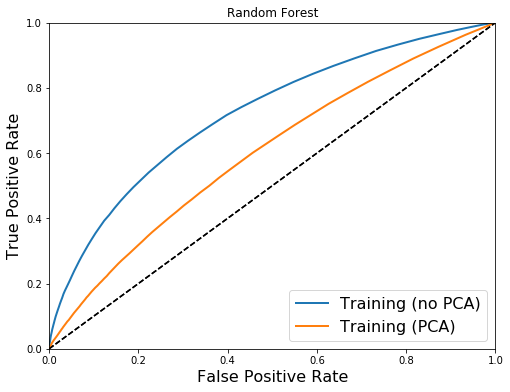

In [113]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Training (no PCA)")
plot_roc_curve(fpr_forest_pca, tpr_forest_pca, "Training (PCA)")
plt.legend(loc="lower right", fontsize=16)
plt.title("Random Forest")
plt.show()

#### Pick the non-PCA classifier as the best one for the train only set

In [117]:
final_model = forest_train_clf
predictions = final_model.predict_proba(testing_df)[:, 1]

#### Create the submission file for the train only set

In [118]:
submit['TARGET'] = predictions
submit.to_csv('random_forest_baseline.csv', index = False)

### With train set and supplementary tables

#### Non-PCA

In [99]:
# Run GridSearch cross validation with Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model_rf = RandomForestClassifier(random_state=123)
param_grid = {'n_estimators': [100, 150, 200, 250]}

grid_search_train_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid , cv=5, scoring='roc_auc')

grid_search_train_rf.fit(training_df_merged, y_train)
    
# Results of the grid search for best n_estimator
print(grid_search_train_rf.best_params_)
print ("------------")

# Results of the grid search in general
cvres = grid_search_train_rf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

{'n_estimators': 250}
------------
0.7211176948604427 {'n_estimators': 100}
0.7274390722625177 {'n_estimators': 150}
0.7304334218561259 {'n_estimators': 200}
0.7328253076515198 {'n_estimators': 250}


In [100]:
# Find BEST model
from sklearn.model_selection import cross_val_predict

forest_merge_clf = grid_search_train_rf.best_estimator_
y_probas_merge_forest = cross_val_predict(forest_merge_clf, training_df_merged, y_train, cv=5, method="predict_proba")
y_scores_merge_forest = y_probas_merge_forest[:, 1] 
fpr_merge_forest, tpr_merge_forest, thresholds_merge_forest = roc_curve(y_train, y_scores_merge_forest)

#### PCA

In [101]:
# Run GridSearch cross validation with Random Forest

grid_search_pac_train_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid , cv=5, scoring='roc_auc')

grid_search_pac_train_rf.fit(X_train_merged_reduced, y_train)
    
# Results of the grid search for best n_estimator
print(grid_search_pac_train_rf.best_params_)
print ("------------")

# Results of the grid search in general
cvres = grid_search_pac_train_rf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

{'n_estimators': 250}
------------
0.6390463142098564 {'n_estimators': 100}
0.6447005541384105 {'n_estimators': 150}
0.6473498987500164 {'n_estimators': 200}
0.6491888007241611 {'n_estimators': 250}


In [105]:
# Find BEST model
forest_pca_merge_clf = grid_search_pac_train_rf.best_estimator_
y_probas_pca_merge = cross_val_predict(forest_pca_merge_clf, X_train_merged_reduced, y_train, cv=5, method="predict_proba")
y_scores_pca_merge = y_probas_pca_merge[:, 1] 
fpr_pca_merge, tpr_pca_merge, thresholds_pca_merge = roc_curve(y_train, y_scores_pca_merge)

#### Plot the curves

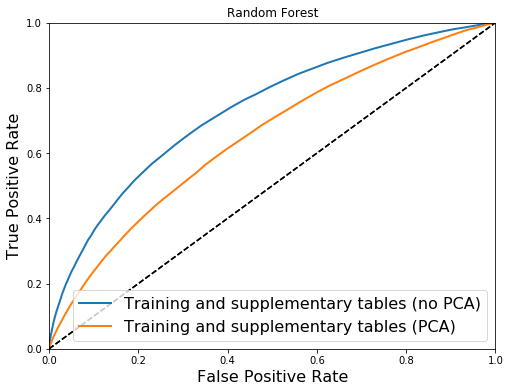

In [106]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_merge_forest, tpr_merge_forest, "Training and supplementary tables (no PCA)")
plot_roc_curve(fpr_pca_merge, tpr_pca_merge, "Training and supplementary tables (PCA)")
plt.legend(loc="lower right", fontsize=16)
plt.title("Random Forest")
plt.show()

#### Pick the non-PCA classifier as the best one for the merged set 

In [107]:
final_model_merged = forest_merge_clf
predictions_merged = final_model_merged.predict_proba(testing_df_merged)[:, 1]

#### Create the submission file for the merged set

In [108]:
submit_merged['TARGET'] = predictions_merged
submit_merged.to_csv('random_forest_merged_baseline.csv', index = False)

### Save preprocessed data to file (to be used in future notebooks)

In [109]:
training_df.to_csv('training_preprocessed.csv', index = False)
training_df.to_csv('testing_preprocessed.csv', index = False)
training_df_merged.to_csv('training_merged_preprocessed.csv', index = False)
testing_df_merged.to_csv('testing_merged_preprocessed.csv', index = False)

### Save model to file (for possible future use)

In [120]:
from sklearn.externals import joblib
joblib.dump(final_model, 'final_model.pkl')
joblib.dump(final_model_merged, 'final_model_merged.pkl')

# Load the model from the file
# clf_from_joblib = joblib.load('filename.pkl') 
# Use the loaded model to make predictions
# clf_from_joblib.predict(X)

['final_model_merged.pkl']

### Feature Importance

As PCA returned not-so-good results, we could look at feature selection based on their importance.  
Collect the features now, which we will use for future work.

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model_rf = RandomForestClassifier(random_state=123)
param_grid = {'n_estimators': [200]}

grid_search_train_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid , cv=5, scoring='roc_auc')

grid_search_train_rf.fit(training_df, y_train)

print(grid_search_train_rf.best_params_)

final_model = grid_search_train_rf.best_estimator_

{'n_estimators': 200}


In [114]:
# On train set
features = list(training_df.columns)
feature_importance_values = final_model.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

In [116]:
# On train set and supplementary tables
features = list(training_df_merged.columns)
feature_importance_values_merged = final_model_merged.feature_importances_
feature_importances_merged = pd.DataFrame({'feature': features, 'importance': feature_importance_values_merged})

In [129]:
# Plot the top n importance
def plot_feature_importances(df, n):
    
    size = int(n/2)
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, size))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:n]))), 
            df['importance_normalized'].head(n), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:n]))))
    ax.set_yticklabels(df['feature'].head(n))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

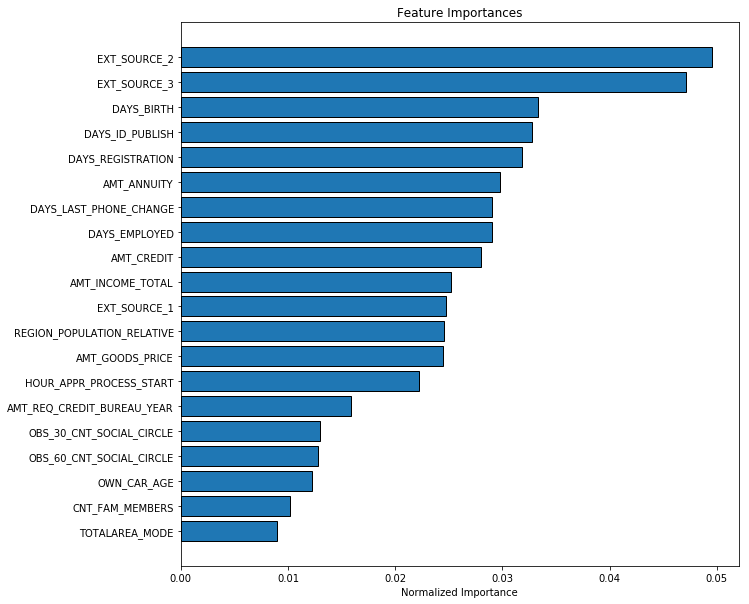

In [130]:
feature_importances_sorted = plot_feature_importances(feature_importances, 20)

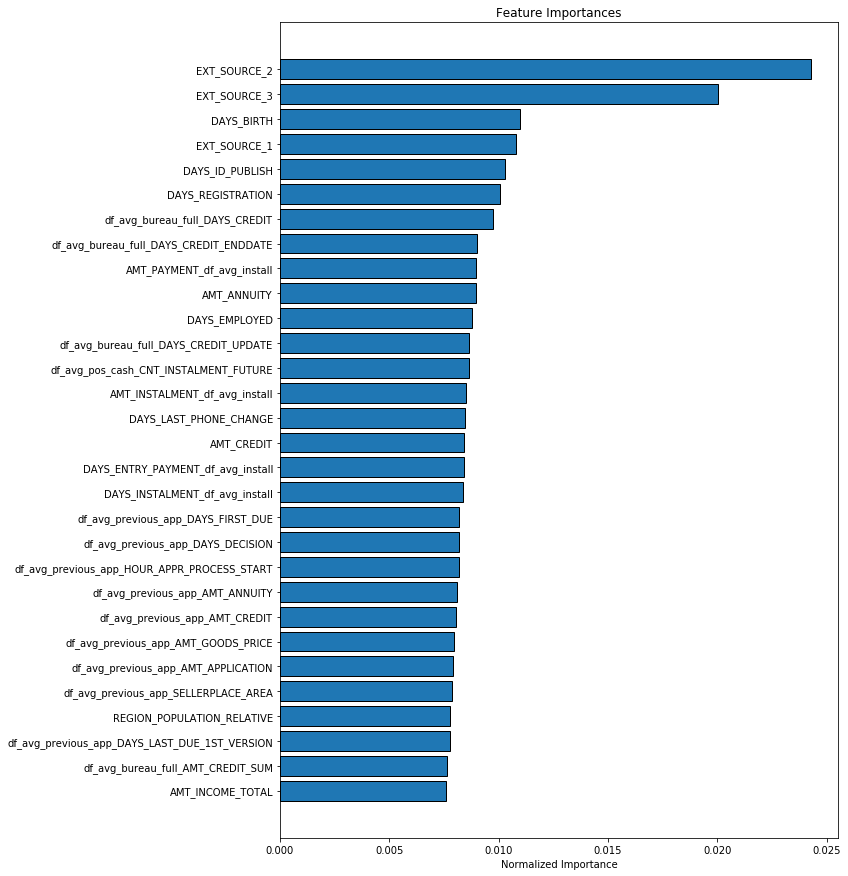

In [131]:
feature_importances_merged_sorted = plot_feature_importances(feature_importances_merged, 30)

### Save the feature importance to file (to be used in future notebooks)

In [132]:
feature_importances_sorted.to_csv('feature_importances_sorted.csv', index = False)
feature_importances_merged_sorted.to_csv('feature_importances_merged_sorted.csv', index = False)

### Submission Scores
#### Test set only: 0.671
#### Test and merged supplementary tables: 0.703